# Eigenfarms
* Method to add value to networks
* A way to Spatial Simplify large geospatial datasets
* Provide Rankings
* Looks at clustering

## Imports

In [15]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [16]:
def convert_GeoPandas_to_Bokeh_format(gdf):
    """
    Function to convert a GeoPandas GeoDataFrame to a Bokeh
    ColumnDataSource object.
    
    :param: (GeoDataFrame) gdf: GeoPandas GeoDataFrame with polygon(s) under
                                the column name 'geometry.'
                                
    :return: ColumnDataSource for Bokeh.
    """
    gdf_new = gdf.drop('geometry', axis=1).copy()
    gdf_new['x'] = gdf.apply(getGeometryCoords, 
                             geom='geometry', 
                             coord_type='x', 
                             shape_type='polygon', 
                             axis=1)
    
    gdf_new['y'] = gdf.apply(getGeometryCoords, 
                             geom='geometry', 
                             coord_type='y', 
                             shape_type='polygon', 
                             axis=1)
    
    return ColumnDataSource(gdf_new)

In [17]:
def getGeometryCoords(row, geom, coord_type, shape_type):
    """
    Returns the coordinates ('x' or 'y') of edges of a Polygon exterior.
    
    :param: (GeoPandas Series) row : The row of each of the GeoPandas DataFrame.
    :param: (str) geom : The column name.
    :param: (str) coord_type : Whether it's 'x' or 'y' coordinate.
    :param: (str) shape_type
    """
    
    # Parse the exterior of the coordinate
    if shape_type == 'polygon':
        exterior = row[geom].exterior
        if coord_type == 'x':
            # Get the x coordinates of the exterior
            return list( exterior.coords.xy[0] )    
        
        elif coord_type == 'y':
            # Get the y coordinates of the exterior
            return list( exterior.coords.xy[1] )

    elif shape_type == 'point':
        exterior = row[geom]
    
        if coord_type == 'x':
            # Get the x coordinates of the exterior
            return  exterior.coords.xy[0][0] 

        elif coord_type == 'y':
            # Get the y coordinates of the exterior
            return  exterior.coords.xy[1][0]

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import ancil_load
import ancil_analytics
import datetime as dt
import ancil_bokeh

ancil_load=reload(ancil_load)
ancil_analytics=reload(ancil_analytics)
ancil_bokeh=reload(ancil_bokeh)

## Loading generation (subtract means)

In [ ]:
df_all_ancil,price = ancil_load.SA_production_price()
df_all_ancil["index"]=df_all_ancil.index
df_all_ancil=df_all_ancil.drop_duplicates("index")
df_all_ancil=df_all_ancil.drop("index",axis=1)
df_all_ancil=df_all_ancil.fillna(0)

price=pd.DataFrame(price)
price["index"]=price.index
price=price.drop_duplicates("index")
price=price.drop("index",axis=1)
price=pd.Series(price)

df_all=df_all_ancil.loc[dt.datetime(2017,1,1):dt.datetime(2017,2,1)]

# subtract mean if we are looking for mxm or the U
#df=df-df.mean(axis=1)
# subtract mean if we are looking for nxn or the V
dfmean=df_all.mean(axis=0)
df=df_all.subtract(dfmean)

## Calculate SVD

In [6]:
# Can be a slow step or kill the computer
u,s,v=np.linalg.svd(df)

## Project onto eigenvectos -> m points on pc plot -> can filter

In [7]:
# making all the principal components
principle = pd.DataFrame()
for i in range(v.shape[0]):
    principle["PC{0}".format(i+1)]=v[i,:]
    

In [8]:
PC1=v[0,:]
PC2=v[1,:]
PC3=v[2,:]

# C is the projecitons in time onto the eignvectr
C1=np.dot(df,PC1)
C2=np.dot(df,PC2)
C3=np.dot(df,PC3)

PCA=pd.DataFrame({"PC1":C1,"PC2":C2,"PC3":C3},index=df.index)
PCA["timestamp"]=PCA.index
PCA["month"]=np.array(np.array(PCA.index.month))
PCA["day"]=np.array(np.array(PCA.index.day))


import seaborn as sns
### Optional Plot
# # PCA1 Vs PC2
# sns.lmplot(data=PCA,x="PC1",y="PC2",hue="gen",fit_reg=False)
# sns.lmplot(data=PCA,x="PC1",y="PC2",hue="Geography",fit_reg=False)

# # PCA1 VC PC3
# sns.lmplot(data=PCA,x="PC1",y="PC3",hue="gen",fit_reg=False)
# sns.lmplot(data=PCA,x="PC1",y="PC3",hue="Geography",fit_reg=False)

# # Looking at timeseries underneath
# df[["SNOWNTH1","HDWF3","CLEMGPWF","LKBONNY2"]].plot()

## Mapping fisrt Eigenwindfarm loadings onto geospatial

In [9]:
# Very Nice tutorial on using geospatial data
# http://www.bigendiandata.com/2017-06-27-Mapping_in_Jupyter/

In [10]:
import geopandas as gpd
base=gpd.read_file("/mnt/y/Data/geospatial/sa_lga_polygon_shp/SA_LGA_POLYGON_shp/")

In [11]:
import geopandas
from shapely.geometry import Point

list(df.columns)
geolocate=pd.read_excel("/mnt/y/Data/Electricity/Generatorinfo/AEMO/SA_location_date.xlsx")
geolocate.index=geolocate["Wind Farm"]
geolocate=geolocate.loc[df.columns]


# fiddle with this to force it to be between 0 and 1
geolocate["PC1"]=PC1
geolocate["PC1_r"]=abs(PC1*.3)

geolocate["PC2"]=PC2
geolocate["PC2_r"]=abs(PC2*.3)

geolocate["PC3"]=PC3
geolocate["PC3_r"]=abs(PC3*.3)

geolocate['Coordinates']=list(zip(geolocate.Longitude,geolocate.Latitude))
geolocate["Coordinates"]=geolocate["Coordinates"].apply(Point)
geolocate=geopandas.GeoDataFrame(geolocate,geometry='Coordinates')

# ax=base.plot()
# locate.plot(ax=ax,color="red")


In [12]:
from bokeh.models.widgets import Panel, Tabs
from bokeh.io import output_file, show
from bokeh.plotting import figure

output_file("slider.html")

tabs=[]
for i in range(1,4):
    
    title = "Distribution for Principal {0}".format(i)
    bokeh_frame=ancil_bokeh.bokeh_PCA(geolocate,i,title)
    f1 = figure(plot_width=300, plot_height=300)
    tabs.append(Panel(child=bokeh_frame,title=title))

tabs=Tabs(tabs=tabs)
    
    
show(tabs)



In [14]:
type(bokeh_frame)

bokeh.plotting.figure.Figure

# Put in WMTS tile sources

In [282]:
%matplotlib notebook

In [17]:
# Need the geolocation of windfarms!
import xarray as xr
import numpy as np
import pandas as pd
import holoviews as hv
import geoviews as gv
import geoviews.feature as gf

import cartopy
from cartopy import crs as ccrs

from bokeh.tile_providers import STAMEN_TONER
from bokeh.models import WMTSTileSource

hv.notebook_extension('bokeh')


tiles = {'OpenMap': WMTSTileSource(url='http://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png')}


ImportError: No module named crs

In [21]:
import cartopy

ImportError: No module named crs

In [19]:
import sys
sys.executable

'/usr/bin/python'

In [22]:
pwd

u'/mnt/y/Code/Analysis/graph/powerdeck'

In [20]:
sys.path

['',
 '/mnt/y/Code/Analysis/graph/powerdeck',
 '/mnt/y/Code/Analysis/graph',
 '/mnt/y/Code/Analysis/barcharts/ancil',
 '/usr/lib/python2.7',
 '/usr/lib/python2.7/plat-x86_64-linux-gnu',
 '/usr/lib/python2.7/lib-tk',
 '/usr/lib/python2.7/lib-old',
 '/usr/lib/python2.7/lib-dynload',
 '/home/peterad/.local/lib/python2.7/site-packages',
 '/usr/local/lib/python2.7/dist-packages',
 '/usr/lib/python2.7/dist-packages',
 '/home/peterad/.local/lib/python2.7/site-packages/IPython/extensions',
 '/home/peterad/.ipython']

In [16]:
%%opts WMTS [width=450 height=250 xaxis=None yaxis=None]
a=hv.NdLayout({name: gv.WMTS(wmts, extents=(0, -90, 360, 90), crs=ccrs.PlateCarree())
            for name, wmts in tiles.items()}, kdims=['Source']).cols(2)

UsageError: Cell magic `%%opts` not found.


## Map the first Eigenwindfarm combintation onto timeseries

principle is dataframe with loadings, aka columns of V

In [ ]:
# As per https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com

In [223]:
projZ=np.dot(df,principle.iloc[:,:2])
df_proj=np.dot(projZ,(principle.iloc[:,:2]).T)
df_proj=pd.DataFrame(df_proj)
df_proj.columns=df.columns

df_proj=df_proj.add(dfmean,axis=1)
df_proj.index=df.index

<IPython.core.display.Javascript object>


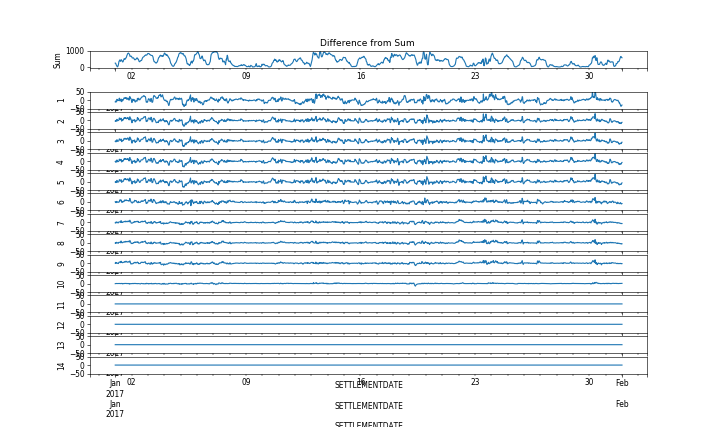

In [242]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.subplot(16,1,1)
plt.title("Difference from Sum ")
df_all.sum(axis=1).plot()
plt.ylabel("Sum")
#plt.rotation(90)
for i in range(2,16):
    plt.subplot(16,1,i+1)
    # aggregating nth PC
    projZ=np.dot(df,principle.iloc[:,:i])
    df_proj=np.dot(projZ,(principle.iloc[:,:i]).T)
    df_proj=pd.DataFrame(df_proj)
    df_proj.columns=df.columns
    df_proj=df_proj.add(dfmean,axis=1)
    df_proj.index=df.index
    (df_all.sum(axis=1)-df_proj.sum(axis=1)).plot()
    plt.ylim((-50,50))
    plt.ylabel(i-1)

In [207]:
plt.show()

## First PC

In [ ]:
df_proj=np.dot(projZ,(principle.iloc[:,:]).T)

<IPython.core.display.Javascript object>


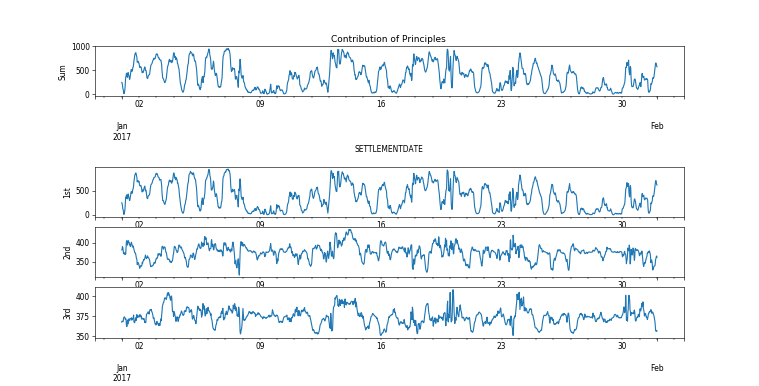

Text(0,0.5,'3rd')

In [255]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.subplot(5,1,1)
plt.title("Contribution of Principles ")
df_all.sum(axis=1).plot()
plt.ylabel("Sum")
#plt.rotation(90)

# First 
plt.subplot(5,1,3)
# aggregating nth PC
projZ=np.dot(df,principle.iloc[:,0:1])
df_proj=np.dot(projZ,(principle.iloc[:,0:1]).T)
df_proj=pd.DataFrame(df_proj)
df_proj.columns=df.columns
df_proj=df_proj.add(dfmean,axis=1)
df_proj.index=df.index
#(df_all.sum(axis=1)-df_proj.sum(axis=1)).plot()
df_proj.sum(axis=1).plot()
plt.ylabel("1st")

# Second
plt.subplot(5,1,4)
# aggregating nth PC
projZ=np.dot(df,principle.iloc[:,1:2])
df_proj=np.dot(projZ,(principle.iloc[:,1:2]).T)
df_proj=pd.DataFrame(df_proj)
df_proj.columns=df.columns
df_proj=df_proj.add(dfmean,axis=1)
df_proj.index=df.index
#(df_all.sum(axis=1)-df_proj.sum(axis=1)).plot()
df_proj.sum(axis=1).plot()
plt.ylabel("2nd")


# Third
plt.subplot(5,1,5)
# aggregating nth PC
projZ=np.dot(df,principle.iloc[:,2:3])
df_proj=np.dot(projZ,(principle.iloc[:,2:3]).T)
df_proj=pd.DataFrame(df_proj)
df_proj.columns=df.columns
df_proj=df_proj.add(dfmean,axis=1)
df_proj.index=df.index
#(df_all.sum(axis=1)-df_proj.sum(axis=1)).plot()
df_proj.sum(axis=1).plot()
plt.ylabel("3rd")

## Second PC

## Third PC

# My best guess how to do it: suspect I am plotting something very different

In [124]:
timeseries=pd.DataFrame()
for i in range(df.shape[1]):
    timeseries["timeseries{0}".format(i+1)]=np.array(df.multiply(np.array(principle["PC{0}".format(i+1)]),axis=1)).sum(axis=1)
timeseries.index = df.index

In [125]:
%matplotlib notebook

<IPython.core.display.Javascript object>


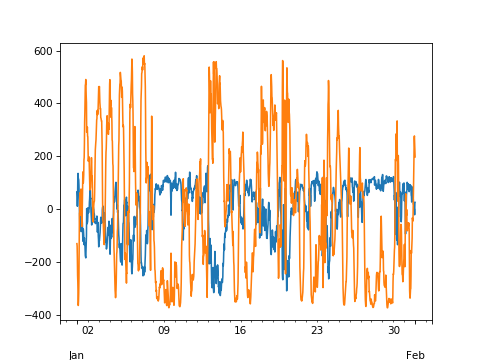

In [130]:
timeseries.sum(axis=1).plot()
df.sum(axis=1).plot()

<IPython.core.display.Javascript object>


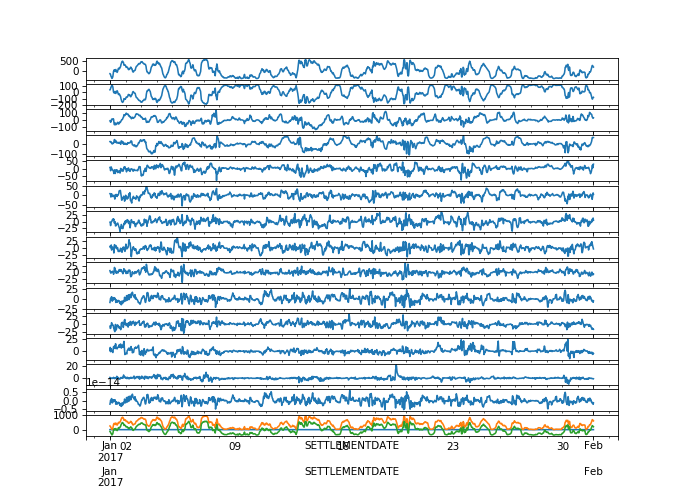

In [131]:
import matplotlib.pyplot as plt
plt.subplot(15,1,1)
df.sum(axis=1).plot()
for i in range(1,15):
    plt.subplot(15,1,i+1)
    timeseries.iloc[:,i-1].plot()
